In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import cv2
from glob import glob
import os
from tqdm import tqdm, trange
import torch.nn as nn
import torch.nn.functional as F

from loss import SAATDLoss, SAATGLoss
from model import get_generator, get_dis_non_makeup, get_dis_makeup

In [2]:
root_dir = "../SSAT_data"

img_files = sorted(glob(os.path.join(root_dir, "data_img/*")))
seg_files = sorted(glob(os.path.join(root_dir, "data_seg/*")))

In [3]:
# 14
# max = 0
# for seg_file in tqdm(seg_files):
#     seg = plt.imread(seg_file)
#     curr_max = np.unique(seg * 255).max()
#     if curr_max > max:
#         max = curr_max
# max

In [4]:
data_img_1 = "../SSAT_data/data_img/012ce0437aec38b7b42918f3e4971c13.png"
data_seg_1 = "../SSAT_data/data_seg/012ce0437aec38b7b42918f3e4971c13.png"
data_img_2 = "../SSAT_data/data_img/vRX56.png"
data_seg_2 = "../SSAT_data/data_seg/vRX56.png"


img_1 = plt.imread(data_img_1)
seg_1 = plt.imread(data_seg_1)
img_2 = plt.imread(data_img_2)
seg_2 = plt.imread(data_seg_2)


img_1 = cv2.resize(img_1, (256, 256))
seg_1 = cv2.resize(seg_1, (256, 256))
img_2 = cv2.resize(img_2, (256, 256))
seg_2 = cv2.resize(seg_2, (256, 256))

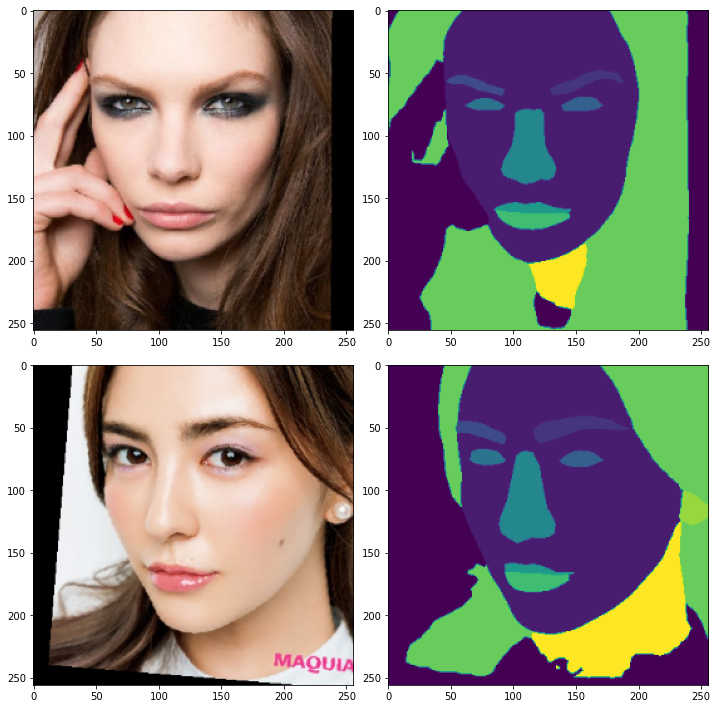

In [5]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].imshow(img_1)
axs[0, 1].imshow(seg_1)
axs[1, 0].imshow(img_2)
axs[1, 1].imshow(seg_2)
plt.tight_layout()
plt.show()

In [6]:
class Opts:
    def __init__(self, opts):
        # for every key in opts, create an attribute in self
        for k, v in opts.items():
            setattr(self, k, v)

opts = Opts({
    "dataroot": '../SSAT_data',
    "phase": 'test',
    "dataset_size": 300,
    "input_dim": 3,
    "output_dim": 3,
    "semantic_dim": 1,
    "batch_size": 1,
    "resize_size": 286,
    "crop_size": 256,
    "flip": True,
    "nThreads": 1,
    "platform": 'GPU',
    "device_id": 0,
    "device_num": 1,
    "name": 'SSAT',
    "outputs_dir": './outputs',
    "print_iter": 100,
    "save_imgs": True,
    "save_checkpoint_epochs": 100,
    "gan_mode": 'lsgan',
    "rec_weight": 1.0,
    "CP_weight": 2.0,
    "GP_weight": 1.0,
    "cycle_weight": 1.0,
    "adv_weight": 1.0,
    "latent_weight": 0.1,
    "semantic_weight": 1.0,
    "init_type": 'normal',
    "init_gain": 0.02,
    "beta1": 0.5,
    "beta2": 0.999,
    "dis_scale": 3,
    "dis_norm": 'None',
    "dis_spectral_norm": True,
    "lr_policy": 'lambda',
    "max_epoch": 1000,
    "n_epochs": 500,
    "n_epochs_decay": 500,
    "resume": None,
    "num_residule_block": 4,
    "lr": 0.0002,
    "device": torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    # "device": torch.device('cpu')
})

In [7]:
G = get_generator(opts)
D_non_makeup = get_dis_non_makeup(opts)
D_makeup = get_dis_makeup(opts)

In [8]:
loss_G = SAATGLoss(opts, G, D_non_makeup, D_makeup)
loss_D = SAATDLoss(opts, D_non_makeup, D_makeup)
criterion = nn.BCELoss()

In [9]:
optimizer_G = torch.optim.Adam(G.parameters(), lr=opts.lr, betas=(opts.beta1, opts.beta2))
optimizer_D = torch.optim.Adam(list(D_non_makeup.parameters()) + list(D_makeup.parameters()), lr=opts.lr, betas=(opts.beta1, opts.beta2))

In [10]:
non_makeup = torch.from_numpy(img_1).permute(2, 0, 1).unsqueeze(0).float().to(opts.device)
non_makeup_parse = torch.from_numpy(seg_1).unsqueeze(0).unsqueeze(0).float().to(opts.device)
makeup = torch.from_numpy(img_2).permute(2, 0, 1).unsqueeze(0).float().to(opts.device)
makeup_parse = torch.from_numpy(seg_2).unsqueeze(0).unsqueeze(0).float().to(opts.device)

In [12]:
num_epochs = 50

# Training Loop
for epoch in range(num_epochs):
    lg, z_transfer, z_removal, z_rec_non_makeup, z_rec_makeup, z_cycle_non_makeup, z_cycle_makeup, mapX, mapY \
      = loss_G(non_makeup, makeup, non_makeup_parse, makeup_parse)
    d_loss = loss_D(non_makeup, makeup, z_transfer, z_removal)

    print("Epoch: ", epoch, "Loss G: ", lg, "Loss D: ", d_loss)

    optimizer_G.zero_grad()
    lg.backward()
    optimizer_G.step()

    lg, z_transfer, z_removal, z_rec_non_makeup, z_rec_makeup, z_cycle_non_makeup, z_cycle_makeup, mapX, mapY \
    = loss_G(non_makeup, makeup, non_makeup_parse, makeup_parse)
    d_loss = loss_D(non_makeup, makeup, z_transfer, z_removal)

    optimizer_D.zero_grad()
    d_loss.backward()
    optimizer_D.step()
    optimizer_D.zero_grad()

Epoch:  0 Loss G:  tensor(3.7881, device='cuda:0', grad_fn=<AddBackward0>) Loss D:  tensor(3.0374, device='cuda:0', grad_fn=<MulBackward0>)


RuntimeError: CUDA out of memory. Tried to allocate 64.00 MiB (GPU 0; 11.75 GiB total capacity; 9.14 GiB already allocated; 71.44 MiB free; 9.23 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF